C:\Users\user\AppData\Local\Temp\ipykernel_16496\2237312268.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_clients_per_cluster = client_features.groupby('Cluster').apply(lambda x: x.nlargest(10, 'Total_Montant')).reset_index(drop=True)
C:\Users\user\AppData\Local\Temp\ipykernel_16496\2237312268.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Montant', y='Nom_CLI', data=cluster_data, ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_16496\2237312268.py:55: FutureWarning: 

Passing `palette` without assigning `

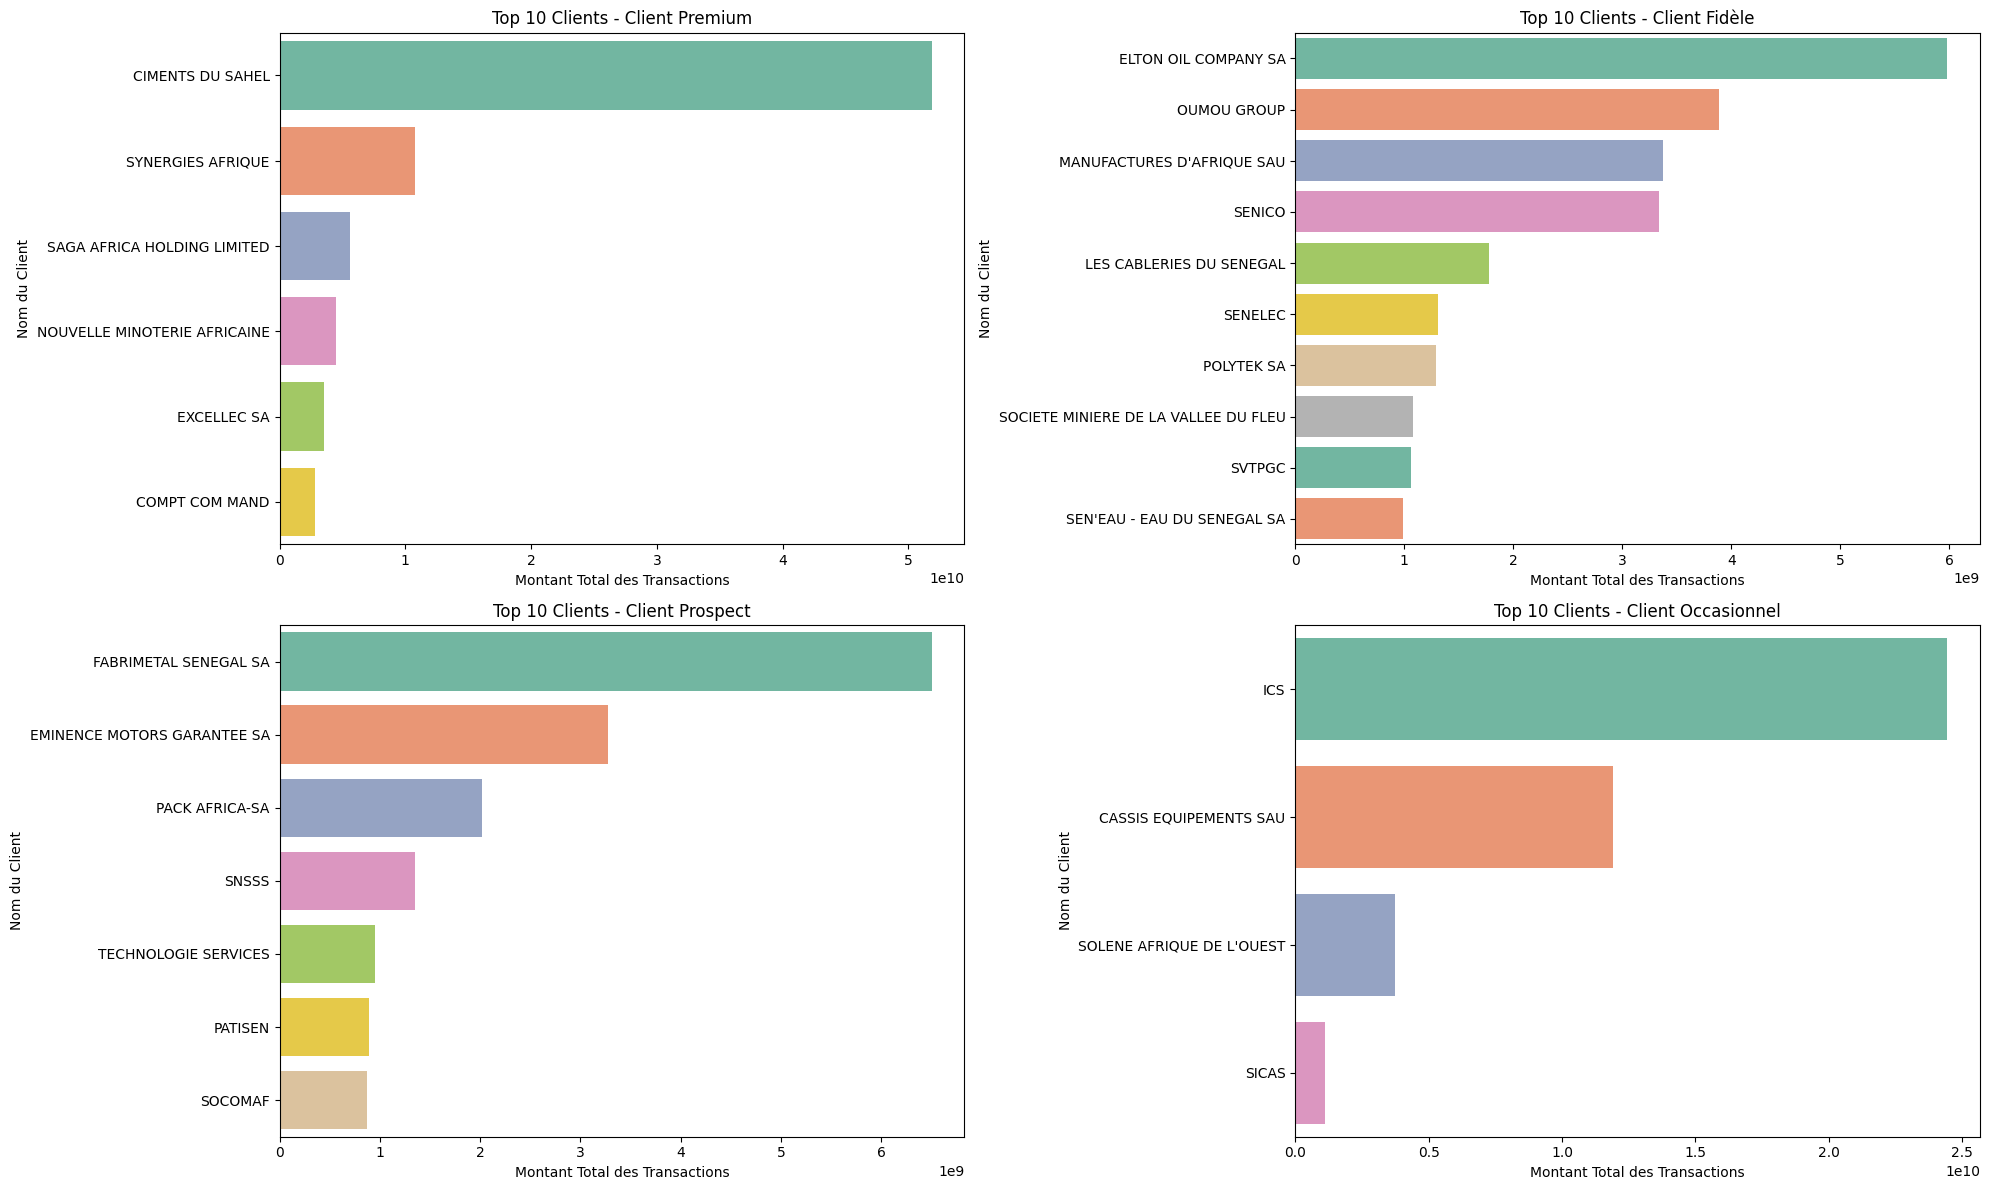

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
file_path = 'Credoc 2019_2024.csv'
credoc_data = pd.read_csv(file_path, delimiter=';')

# Convertir les dates en périodes mensuelles
credoc_data['DOU'] = pd.to_datetime(credoc_data['DOU'], format='%d/%m/%Y', errors='coerce')
credoc_data['Year'] = credoc_data['DOU'].dt.year

# Calculer les caractéristiques pour chaque client
client_features = credoc_data.groupby(['CLI', 'NOM']).agg({
    ' MONT_LOC ': ['sum', 'mean', 'count'],
    'NDOS': pd.Series.nunique,
    'Year': pd.Series.nunique
}).reset_index()

# Renommer les colonnes pour faciliter la manipulation
client_features.columns = ['CLI', 'Nom_CLI', 'Total_Montant', 'Mean_Montant', 'Nb_Transactions', 'Nb_Partenaires', 'Annees_Actives']

# Calculer la fréquence des transactions
client_features['Freq_Transactions'] = client_features['Nb_Transactions'] / client_features['Annees_Actives']

# Normaliser les données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(client_features[['Total_Montant', 'Mean_Montant', 'Nb_Transactions', 'Freq_Transactions', 'Nb_Partenaires', 'Annees_Actives']])

# Appliquer K-means
kmeans = KMeans(n_clusters=4, random_state=42)
client_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Nommer les clusters en fonction des caractéristiques
cluster_names = {
    0: 'Client Premium',  # Clients avec un montant total élevé, un montant moyen élevé, un nombre élevé de transactions, une fréquence de transactions élevée, un nombre élevé de partenaires et plusieurs années actives
    1: 'Client Fidèle',   # Clients avec un montant moyen modéré, un nombre élevé de transactions régulières, une fréquence de transactions modérée, plusieurs partenaires et plusieurs années actives
    2: 'Client Prospect', # Clients avec un montant total faible, un montant moyen faible, un nombre faible de transactions, une fréquence de transactions basse, peu de partenaires et récemment ajoutés
    3: 'Client Occasionnel' # Clients avec un montant total modéré, un montant moyen modéré, un nombre moyen de transactions, une fréquence de transactions sporadique, quelques partenaires et quelques années actives
}
client_features['Cluster_Name'] = client_features['Cluster'].map(cluster_names)

# Déterminer les top 10 clients par cluster
top_clients_per_cluster = client_features.groupby('Cluster').apply(lambda x: x.nlargest(10, 'Total_Montant')).reset_index(drop=True)

# Créer des sous-graphes pour les top 10 clients de chaque cluster
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
clusters = top_clients_per_cluster['Cluster'].unique()

for i, cluster in enumerate(clusters):
    ax = axs[i // 2, i % 2]
    cluster_data = top_clients_per_cluster[top_clients_per_cluster['Cluster'] == cluster]
    sns.barplot(x='Total_Montant', y='Nom_CLI', data=cluster_data, ax=ax, palette='Set2')
    ax.set_title(f'Top 10 Clients - {cluster_names[cluster]}')
    ax.set_xlabel('Montant Total des Transactions')
    ax.set_ylabel('Nom du Client')

plt.tight_layout()
plt.show()
